In [1]:
%env PURE_PYTHON True
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from BTrees.OOBTree import OOBTree
import numpy as np
from collections import Counter
from scipy import stats
import pandas as pd
import pprint
import timeit

CHUNKS_SIZE = 10000
KEY_LENGTH = 8
ALPHABET = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

env: PURE_PYTHON=True


In [2]:
_debug_random_sampling = []
DEFAULT_EXPLORING_STEP = 0

In [3]:
import os
os.environ["PURE_PYTHON"] = "True"

from BTrees.OOBTree import OOBTree as _OOBTree
from collections import Counter
import numpy as np


class OOBTreeExtLean(_OOBTree):
    _fanout_distribution_cache = {}
    _root = None
    _cache_hit_counter = Counter()

    def __init__(self):
        super(OOBTreeExtLean, self).__init__()
        self.walking_path_to_fanout_distribution = {}
        self.default_exploring_step = DEFAULT_EXPLORING_STEP

    def random_sampling(self, k):
        self._first_walk_to_determine_root_coefs()
        self.walking_path_to_fanout_distribution = {}
        all_accept_reject_measures = {
            'accept': [],
            'reject': [],
            'revisited_paths': Counter()
        }

        k = min(len(self), k)
        sampled_values = []
        all_walking_paths_set = set()
        all_walking_paths_stats = []
        while len(sampled_values) < k:
            sampled_value, walking_path, walking_path_stats  = \
                self._get_value_and_path_by_random_walk_from_node(node=self)

            if _this_value_was_sampled_already(walking_path, all_walking_paths_set):
                all_accept_reject_measures['revisited_paths'][str(walking_path)] += 1
                continue

            accept_reject_measures = {
                'path': walking_path,
                'value': sampled_value,
            }

            all_accept_reject_measures['accept'].append(accept_reject_measures)

            all_walking_paths_set.add(str(walking_path))
            all_walking_paths_stats.append(walking_path_stats)
            sampled_values.append(sampled_value)

        add_to_debug_global(locals())

        return sampled_values


    def _calc_fanout_distribution_of_node(self, node):
        if node in self._fanout_distribution_cache:
            self._cache_hit_counter['hit'] += 1
            return self._fanout_distribution_cache[node].copy()
        self._cache_hit_counter['miss'] += 1

        all_sizes = np.array([node.child.size for node in node._data])
        node_distribution = all_sizes / sum(all_sizes)

        self._fanout_distribution_cache[node] = node_distribution
        return node_distribution.copy()

    def _first_walk_to_determine_root_coefs(self):
        self._root = self
        branch_coefs = self._determine_root_to_leaf_walking_probs()
        equations_matrix, equations_equal_matrix = self._create_equations_for_equaling_all_walking_probs(branch_coefs)

        self.root_probs_coefs = np.linalg.solve(equations_matrix, equations_equal_matrix)

    def _create_equations_for_equaling_all_walking_probs(self, branch_coefs):
        root_fanout_distribution = self._calc_fanout_distribution_of_node(node=self)

        equations_matrix = np.zeros((len(branch_coefs) + 1, len(branch_coefs)))
        equations_equal_matrix = np.zeros(len(branch_coefs))

        for root_child_number in range(len(branch_coefs)):
            equations_matrix[root_child_number][0] = branch_coefs[0]
            equations_matrix[root_child_number][root_child_number] = -1 * branch_coefs[root_child_number]
            equations_matrix[-1][root_child_number] = root_fanout_distribution[root_child_number]

        equations_matrix = equations_matrix[1:, ]

        equations_equal_matrix[-1] = 1
        return equations_matrix, equations_equal_matrix

    def _determine_root_to_leaf_walking_probs(self):
        assert self._root, 'must keep _root aside before working with this method'
        root_to_leaf_walking_probs = {}
        root_fanout_distribution = self._calc_fanout_distribution_of_node(self._root)

        for root_child_number in range(len(self._root._data)):
            current_node = self._root
            walking_prob = root_fanout_distribution[root_child_number]
            current_node = current_node._data[root_child_number].child

            while not isinstance(current_node._data[DEFAULT_EXPLORING_STEP].child, self._bucket_type):
                node_fanout_distribution = self._calc_fanout_distribution_of_node(current_node)
                walking_prob *= node_fanout_distribution[0]
                current_node = current_node._data[DEFAULT_EXPLORING_STEP].child

            assert isinstance(current_node._data[DEFAULT_EXPLORING_STEP].child, self._bucket_type)
            walking_prob *= 1 / len(current_node._data)
            root_to_leaf_walking_probs[root_child_number] = walking_prob

        branch_coefs = np.array(list(root_to_leaf_walking_probs.values()))
        return branch_coefs

    def _get_value_and_path_by_random_walk_from_node(self, node):
        walking_path = []
        current_node = node
        prob_along_path = 1
        walking_path_stats = []
        while not isinstance(current_node, self._bucket_type):
            next_random_step, chosen_random_step_prob = self._random_next_move_respect_fanout_prob(
                current_node, walking_path)

            prob_along_path *= chosen_random_step_prob
            walking_path.append((next_random_step, current_node.size, chosen_random_step_prob, prob_along_path))
            current_node = current_node._data[next_random_step].child
            walking_path_stats.append({
                'next_random_step': next_random_step,
                'chosen_random_step_prob':
                    chosen_random_step_prob, 'prob_along_path':prob_along_path})

        next_random_step = np.random.randint(low=0, high=current_node.size)
        chosen_random_step_prob = 1/current_node.max_leaf_size  # todo: size
        prob_along_path *= chosen_random_step_prob
        walking_path.append((next_random_step, current_node.size, chosen_random_step_prob, prob_along_path))
        walking_path_stats.append({
            'next_random_step': next_random_step,
            'chosen_random_step_prob':
                chosen_random_step_prob, 'prob_along_path': prob_along_path,
            'entire_walking_path': walking_path})

        leaf = current_node._keys
        return leaf[next_random_step], walking_path, walking_path_stats

    def _is_root_node(self, node):
        assert self._root
        return node == self._root

    def _random_next_move_respect_fanout_prob(self, current_node, walking_path):
        node_distribution = self._calc_fanout_distribution_of_node(current_node)
        if self._is_root_node(current_node):
            node_distribution *= self.root_probs_coefs
            node_distribution = _fix_distribution_mistake_due_to_floating_calc_errors_if_needed(node_distribution)

        next_random_step = np.random.choice(current_node.size, p=node_distribution)
        
        chosen_random_step_prob = node_distribution[next_random_step]
        return next_random_step, chosen_random_step_prob


    def join(self, right_tree):
        pass


def _fix_distribution_mistake_due_to_floating_calc_errors_if_needed(node_distribution):
    # todo: as it happens only at the root, can fix the coefs
    if sum(node_distribution) == 1:
        return node_distribution

    calc_error = 1 - sum(node_distribution)
    assert calc_error <= 0.0_000_001, 'calculation faults cant be higher than this'
    random_child = np.random.randint(len(node_distribution))
    node_distribution[random_child] += calc_error
    return node_distribution


def add_to_debug_global(all_vars):
    global _debug_random_sampling
    _debug_random_sampling.append({
        'params': {
            'k': all_vars['k'],
        },
        'tree_size': len(all_vars['self']),
        'all_accept_reject_measures': all_vars['all_accept_reject_measures'],
        'all_walking_paths_stats': all_vars['all_walking_paths_stats']
    })


def _this_value_was_sampled_already(walking_path, all_walking_paths_set):
    return str(walking_path) in all_walking_paths_set


In [4]:
def generate_btree_index_x_values_with_dist(num_of_values, disired_prefix_to_percent_dist, my_index=None):
    my_index = my_index if my_index is not None else OOBTreeExt()
    for prefix, amount_percent in disired_prefix_to_percent_dist.items():
        amount = int(num_of_values * amount_percent)
        my_index = insert_to_index_random(my_index, amount, prefix)

    return my_index


def insert_to_index_random(my_index, amount, prefix=''):
    amount_in_iteration = min(CHUNKS_SIZE, amount)
    print('generating %s values, chunk of %s, with prefix=\'%s\'' %(amount, amount_in_iteration, prefix))

    proceed = 0
    for i in range(0, amount, amount_in_iteration):
        alphabet = list(ALPHABET)
        np_alphabet = np.array(alphabet)
        np_codes = np.random.choice(np_alphabet, [amount_in_iteration, KEY_LENGTH])
        my_index.update({
            prefix + ''.join(np_codes[i]): "".join(np_codes[i])
            for i in range(len(np_codes))
        })

        proceed += amount_in_iteration
        if (proceed % 150000) == 0:
            print('done generating %s values' % (proceed))
    return my_index


In [5]:
def _calculate_prefix_ditribution(values):
    return {value: occurences/len(values) for value, occurences in Counter([key[:4] for key in values]).most_common(10)}

In [6]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
print(datetime.utcnow())
num_of_values = 4_000_000
my_index_4m = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
print(datetime.utcnow())

2021-02-08 07:33:14.818561
generating 1000000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
generating 600000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
generating 400000 values, chunk of 10000, with prefix='mmmm'
done generating 150000 values
done generating 300000 values
generating 120000 values, chunk of 10000, with prefix='rrrr'
generating 1880000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done g

In [7]:
print(datetime.utcnow())
sampled = my_index_4m.random_sampling(k=10_000)
print(datetime.utcnow()) # to 11 seconds 

2021-02-08 07:36:42.433974
2021-02-08 07:36:47.055476


In [13]:
pd.DataFrame([x[:4] if x[:4] in prefix_to_percent else 'other' for x in sampled]).to_csv('sampled_10k.csv')

In [15]:
df = pd.DataFrame([x[:4] if x[:4] in prefix_to_percent else 'other' for x in my_index_4m.keys()])

In [27]:
df.to_csv('entire_4m_data.csv')

In [26]:
print(4000000 * 0.03)
prefix_to_percent

120000.0


{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}

In [83]:
## Tools for analyze results

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def _calculate_prefix_ditribution(values):
    return {value: occurences/len(values) for value, occurences in Counter([key[:4] for key in values]).most_common(10)}

def _compute_kl_divergence_and_other_to_df(df):
    dist_vec_real = df[['gggg','hhhh','mmmm','rrrr']].values[0]
    df['other'] = 1 - df[['gggg', 'hhhh', 'mmmm', 'rrrr']].sum(axis=1)
    df['kl_diver_from_real'] = df[['gggg','hhhh','mmmm','rrrr']].apply(kl_divergence, axis=1, args=(dist_vec_real,))
    return df

def _draw_plots_comparing_algo_to_real(how_to_walk, df):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
    for i, sample_size in enumerate([500, 5000, 10000]):
        # TODO: instead of None, write explicity access to the row with the real values
        df_by_walk = df[df['how_to_walk'].isin([how_to_walk, None])] 
        df_by_walk_and_sample = df_by_walk[df_by_walk['sample_size'].isin([sample_size,1_000_000])]
        df_by_walk_and_sample = df_by_walk_and_sample.drop(
            ['sample_size' ,'kl_diver_from_real','running_time'], axis=1)
        df_by_walk_and_sample.plot(kind='bar', ax=axes[i], x='id')



def _random_sampling_to_measure(my_index, how_to_walk, df, sample_sizes=None, times_each=None):
    sample_sizes = sample_sizes or (500, 5_000, 10_000)
    times_each = times_each or list(range(3))
    for sample_size in sample_sizes:
        for i in times_each:
            print (f'i={i}, sample_size={sample_size}')
            start_time = timeit.default_timer()
            samples = my_index.random_sampling(k=sample_size)
            time_passed = timeit.default_timer() - start_time
            assert len(samples) == sample_size
            samples_dist = _calculate_prefix_ditribution(samples)
            df = df.append([
                {'id': f'sampled_{sample_size}_round_{i}', 'how_to_walk': how_to_walk, 'sample_size': sample_size ,
                 'running_time': time_passed,
                 **{x:y for x,y in samples_dist.items() if x in prefix_to_percent}}])
            print (f'i={i}, sample_size={sample_size}')
    return df


In [84]:
random_sampling_df = pd.DataFrame([{'id': 'real', 'how_to_walk': None, 'sample_size': len(my_index_4m), **prefix_to_percent}])
random_sampling_df.rename(columns={'': 'other'}, inplace=True)


In [92]:
random_sampling_df = _random_sampling_to_measure(my_index_4m, how_to_walk=None, df=random_sampling_df)
random_sampling_df = _compute_kl_divergence_and_other_to_df(random_sampling_df)
random_sampling_df

,id,how_to_walk,sample_size,gggg,hhhh,mmmm,rrrr,other,running_time,kl_diver_from_real
0,real,distribution_oriented,4000000,0.2500,0.1500,0.1000,0.0300,0.4700,NaN,0.000000
0,sampled_500_round_0,distribution_oriented,500,0.2520,0.1360,0.1220,0.0240,0.4660,1.360305,0.007587
0,sampled_500_round_1,distribution_oriented,500,0.2600,0.1480,0.0920,0.0240,0.4760,1.168071,-0.004816
0,sampled_500_round_2,distribution_oriented,500,0.2540,0.1220,0.0960,0.0360,0.4920,1.122167,-0.018530
0,sampled_5000_round_0,distribution_oriented,5000,0.2490,0.1416,0.1026,0.0310,0.4758,2.170796,-0.005508
0,sampled_5000_round_1,distribution_oriented,5000,0.2530,0.1436,0.1000,0.0356,0.4678,2.076693,0.002849
0,sampled_5000_round_2,distribution_oriented,5000,0.2502,0.1452,0.0988,0.0346,0.4712,2.149097,-0.000779
0,sampled_10000_round_0,distribution_oriented,10000,0.2422,0.1544,0.1025,0.0320,0.4689,3.340969,0.001383
0,sampled_10000_round_1,distribution_oriented,10000,0.2467,0.1500,0.1011,0.0334,0.4688,3.228704,0.001414
0,sampled_10000_round_2,distribution_oriented,10000,0.2540,0.1510,0.1004,0.0281,0.4665,3.334205,0.003597


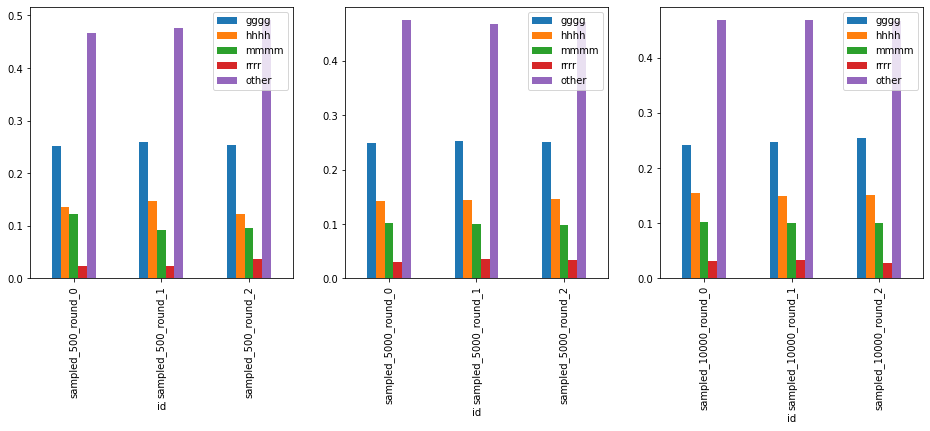

In [90]:
_draw_plots_comparing_algo_to_real(how_to_walk=None ,df=random_sampling_df)

In [91]:
random_sampling_df['how_to_walk']='distribution_oriented'

In [93]:
my_index_4m.random_sampling

SyntaxError: invalid syntax (<ipython-input-93-3c0a9cabfbfe>, line 1)